# PIV basics 1 

 start analasys of two picture from piv challenge going through the steps in PIV basics

In [2]:
import numpy as np
from matplotlib import pyplot as plt

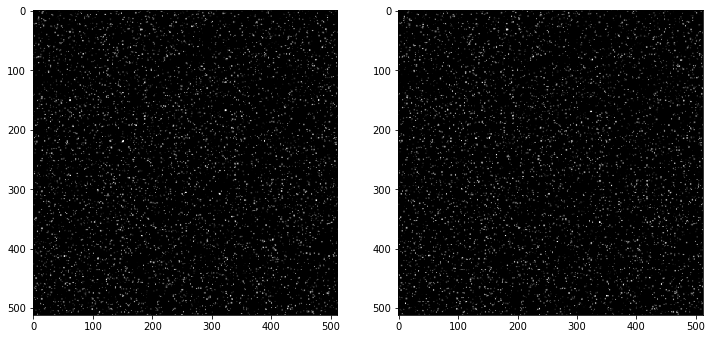

In [21]:

# load the images: 
a = plt.imread('B005_1.tif')
b = plt.imread('B005_2.tif')
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(a,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(b,cmap="gray")

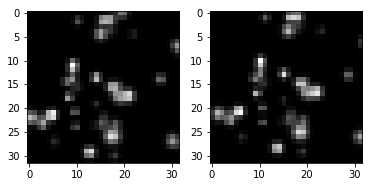

In [4]:
#interrogation windows. 
size=32 #size 32X32
ia = a[:size,:size].copy()
ib = b[:size,:size].copy()
plt.figure()
plt.subplot(1,2,1)
plt.imshow(ia,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(ib,cmap='gray')

let's look at the sustraction of both sub images: $im_a-im_b$ in order to spot the differences

Text(0.5,1,'Without shift')

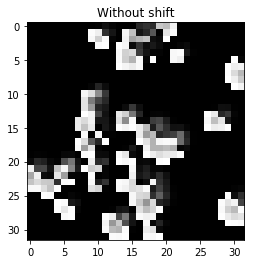

In [5]:
#lets start with simple substraction to find the displacemants between a to b
plt.imshow(ib-ia,cmap='gray')
plt.title('Without shift')

So the images are defenetley not the same. lets try to shift $image_a$ by 1 pixel 

Text(0.5,1,'Difference when IA has been shifted by 1 pixel')

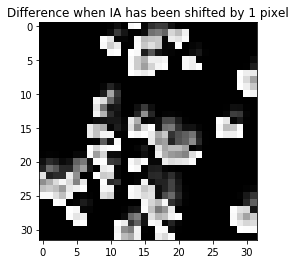

In [6]:
# lets shift ia by 1 pixle down
plt.imshow(ib-np.roll(ia,1,axis=0),cmap='gray')
plt.title('Difference when IA has been shifted by 1 pixel')

let's try to find the displacemant by going through all the combinations considering the maximun posible diplacemant is 8 pixels in each axis.

In [7]:
#lets find the displacemant
def match_template(img, template,maxroll=8):
    mindist = float('inf')
    idx = (-1,-1)
    for y in range(-maxroll,maxroll+1):
        for x in range(-maxroll,maxroll+1):
        #calculate Euclidean distance
            dist = np.sqrt(np.sum(np.square(template - np.roll(img,(x,y),axis=(0,1)))))
            if dist < mindist:
                mindist = dist
                idx = (x,y)
                
    return [mindist, idx]

In [8]:
# let's test that it works indeed by manually rolling (shifting circurlarly) the same image
match_template(ia,np.roll(ia,2,axis=0))

[0.0, (2, 0)]

it worked! we got zero distance and a displacemant of 2 pixels exactly what we expected.
let's apply it on the sub pictures.

In [9]:
# indeed, when we find the correct shift, we got zero distance. it's not so in real images:
mindist, idx = match_template(ia,ib)
print('Minimal distance = %f' % mindist)
print('idx = %d, %d' % idx)

Minimal distance = 123.802262
idx = -1, 1


firstly, the minimal distance is defentely not zero. But maybe it's good enough lets see the substraction on $im_b(i,j)-im_a(i,j+1)$

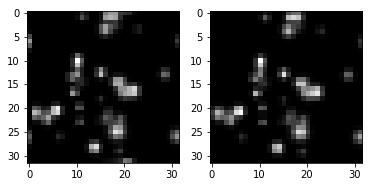

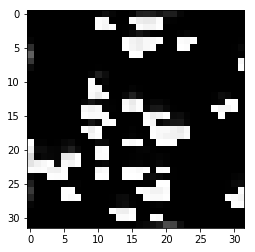

In [10]:
#lets check if it looks the same
plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.roll(ia,idx,(0,1)),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(ib,cmap='gray')
plt.figure()
plt.imshow(np.roll(ia,idx,(0,1))-ib,cmap='gray')

Well it's not the exact shift indeed, but it is closer than before.
let's find all the shifts and time it using the simple algoritm we intreduced here.

In [31]:
i,j=np.shape(a)
print(i)
print(j)
size=32
Xwin_num=i/32 #number of windows given size of sizeXsize pixels of each window
Ywin_num=j/32 # "---"
cor, dispx, dispy=-10*np.ones([Xwin_num,Ywin_num]), -10*np.ones([Xwin_num,Ywin_num]), -10*np.ones([Xwin_num,Ywin_num])
for X in range(Xwin_num):
    for Y in range(Ywin_num):
        #print(X,Y)
        ia=a[X*size:(X+1)*size,Y*size:(Y+1)*size].copy()
        ib=b[X*size:(X+1)*size,Y*size:(Y+1)*size].copy()
        cor[X,Y], (dispx[X,Y],dispy[X,Y]) = match_template(ia,ib)
        

        
    

512
512


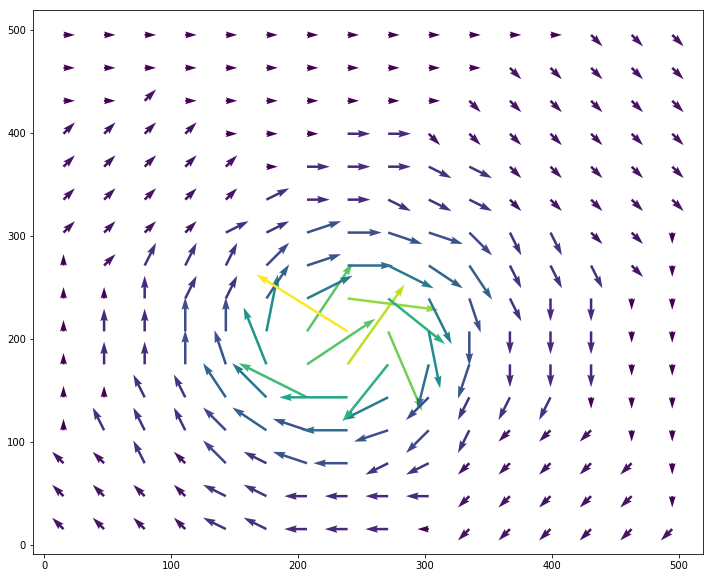

In [34]:
plt.figure(figsize=(12,10))
x = np.arange(size/2-1, i, size)
y = np.arange(size/2-1, i, size)
Y, X = np.meshgrid(y, x)
M = np.sqrt(pow(dispx, 2) + pow(dispy, 2))
q = plt.quiver(X, Y, dispx, dispy,M)
plt.show()

## lets try using cross corelation

In [25]:
from scipy.signal import correlate2d
ia = a[:size,:size].copy()
ib = b[:size,:size].copy()
c = correlate2d(ia-ia.mean(),ib-ib.mean())
# not it's twice bigger than the original windows, as we can shift ia by maximum it's size horizontally and vertically
print('Size of the correlation map %d x %d' % c.shape)

Size of the correlation map 63 x 63


Text(0.5,0.92,'Correlation map - peak is the most probable shift')

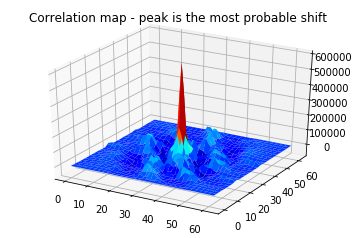

In [26]:
# let's see how the correlation map looks like:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cx,cy = np.meshgrid(range(c.shape[0]), range(c.shape[1]))

ax.plot_surface(cx,cy,c,cmap= "jet", linewidth=0.2)
plt.title('Correlation map - peak is the most probable shift')

i = 32, j= 30


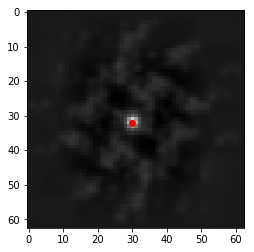

In [27]:
plt.imshow(c, cmap='gray')

i,j = np.unravel_index(c.argmax(), c.shape)

print('i = {}, j= {}'.format(i,j))

plt.plot(j,i,'ro')

In [51]:
iw = 32

x,y,u,v = [],[],[],[]
for k in range(0,a.shape[0],iw):
    for m in range(0,a.shape[1],iw):
        ia = a[k:k+iw,m:m+iw]
        ib = b[k:k+iw,m:m+iw]
        c = correlate2d(ia-ia.mean(),ib-ib.mean())
        i,j = np.unravel_index(c.argmax(), c.shape)
        x.append(k+iw/2.-1)
        y.append(m+iw/2.-1)
        u.append(i - 31)
        v.append(j - 31)

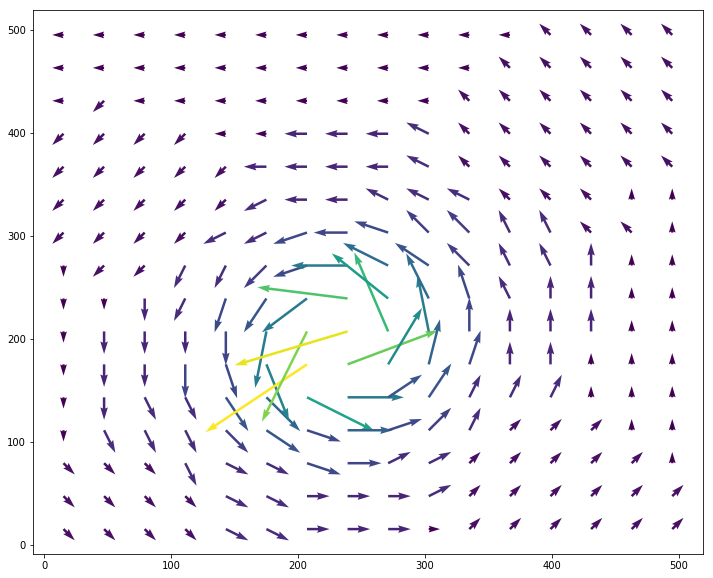

In [54]:
plt.figure(figsize=(12,10))
M = np.sqrt(pow(np.array(u), 2) + pow(np.array(v), 2))
plt.quiver(x,y,u,v,M)

it's a vortex in the oposite direction compared to the privious method. well it's because our axis were upside down. let's fix it.

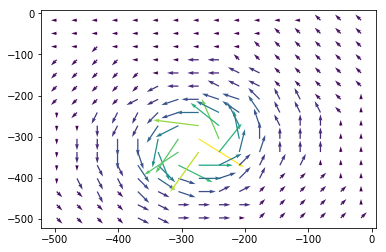

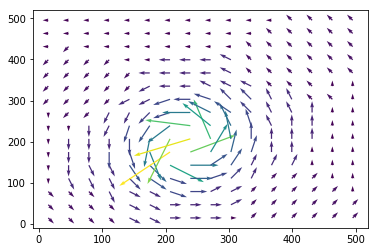

In [103]:
plt.figure()
M = np.sqrt(pow(dispx, 2) + pow(dispy, 2))
q = plt.quiver((X-a.shape[0]), (Y-a.shape[0]), -1*dispx,-1*dispy,M)
plt.figure()
M = np.sqrt(pow(np.array(u), 2) + pow(np.array(v), 2))
plt.quiver(x,y,u,v,M)